In [2]:
# Imports
import pandas as pd
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Setup; data loading and cleaning
data_file = "/home/davidb/DESTv2_data_paper/15.demographic_inference/output/moments_output_CLL_validation.tsv"
max_num_params = 8
est_cols = ['est' + str(i) for i in range(max_num_params)]

# Read in data
df = pd.read_csv(data_file, sep='\t', header=None,
                     names=['model', 'pop_of_interest'] + \
                           ['init' + str(i) for i in range(max_num_params)] + \
                           est_cols + \
                           ['upper_bound' + str(i) for i in range(max_num_params)] + \
                           ['log_likelihood', 'collapsed_pop_ll', 'func_calls', 'grad_calls',
                            'maxiter', 'hour_limit',
                            'jackknife_id', 'region'])
df['dem_rep'] = df['jackknife_id'].str.split('_').apply(lambda x: x[0])
df['sim_rep'] = df['jackknife_id'].str.split('_').apply(lambda x: x[1])
df['sim_model'] = np.repeat(['one_pop', 'split'] * 2, 6400)
df['fit_model'] = df['model']
df = df.loc[:, ['region', 'sim_model', 'fit_model', 
                'dem_rep', 'sim_rep', 'log_likelihood', 'collapsed_pop_ll']]

In [4]:
# Get the best fit from each pair of moments runs for each replicate
df = df.loc[df.groupby(['region', 'sim_model', 'fit_model', 'dem_rep', 'sim_rep'])['log_likelihood'].idxmax()]

In [5]:
# Calculate p-values for CLL-based model selection on each of dem_reps=40 simulations.
# H0: The one_pop model is not better than the split model.
# H1: The one_pop model is better than the split model.
p_vals_pre_df = {}
for region in ['mainland', 'Americas']:
    for sim_model in ['one_pop', 'split']:
        p_vals = []
        for dem_rep in df['dem_rep'].unique():
            df_temp = df.loc[(df['region'] == region) & 
                             (df['sim_model'] == sim_model) & 
                             (df['dem_rep'] == dem_rep)]
            df_temp = df_temp.sort_values('sim_rep')
            lls = df_temp.loc[df_temp['fit_model'] == 'one_pop', 'log_likelihood'].values
            clls = df_temp.loc[df_temp['fit_model'] == 'split', 'collapsed_pop_ll'].values
            p_vals.append(scipy.stats.wilcoxon(lls, clls, alternative="greater").pvalue)
        p_vals_pre_df[f"{region}_{sim_model}"] = p_vals
p_vals_df = pd.DataFrame(p_vals_pre_df)
p_vals_df.columns = ['mainland x one-pop', 'mainland x split', 'Americas x one-pop', 'Americas x split']

In [6]:
conf_df = pd.DataFrame({'mainland x one-pop': [sum(p_vals_df['mainland x one-pop'] < 0.05),
                                               sum(p_vals_df['mainland x one-pop'] > 0.05)],
                        'mainland x split': [sum(p_vals_df['mainland x split'] < 0.05),
                                               sum(p_vals_df['mainland x split'] > 0.05)],
                        'Americas x one-pop': [sum(p_vals_df['Americas x one-pop'] < 0.05),
                                               sum(p_vals_df['Americas x one-pop'] > 0.05)],
                        'Americas x split': [sum(p_vals_df['Americas x split'] < 0.05),
                                               sum(p_vals_df['Americas x split'] > 0.05)]})
conf_df /= len(p_vals_df)
conf_df.index = ['one-pop selected', 'split selected']
conf_df

,mainland x one-pop,mainland x split,Americas x one-pop,Americas x split
one-pop selected,0.9,0.0,0.875,0.0
split selected,0.1,1.0,0.125,1.0


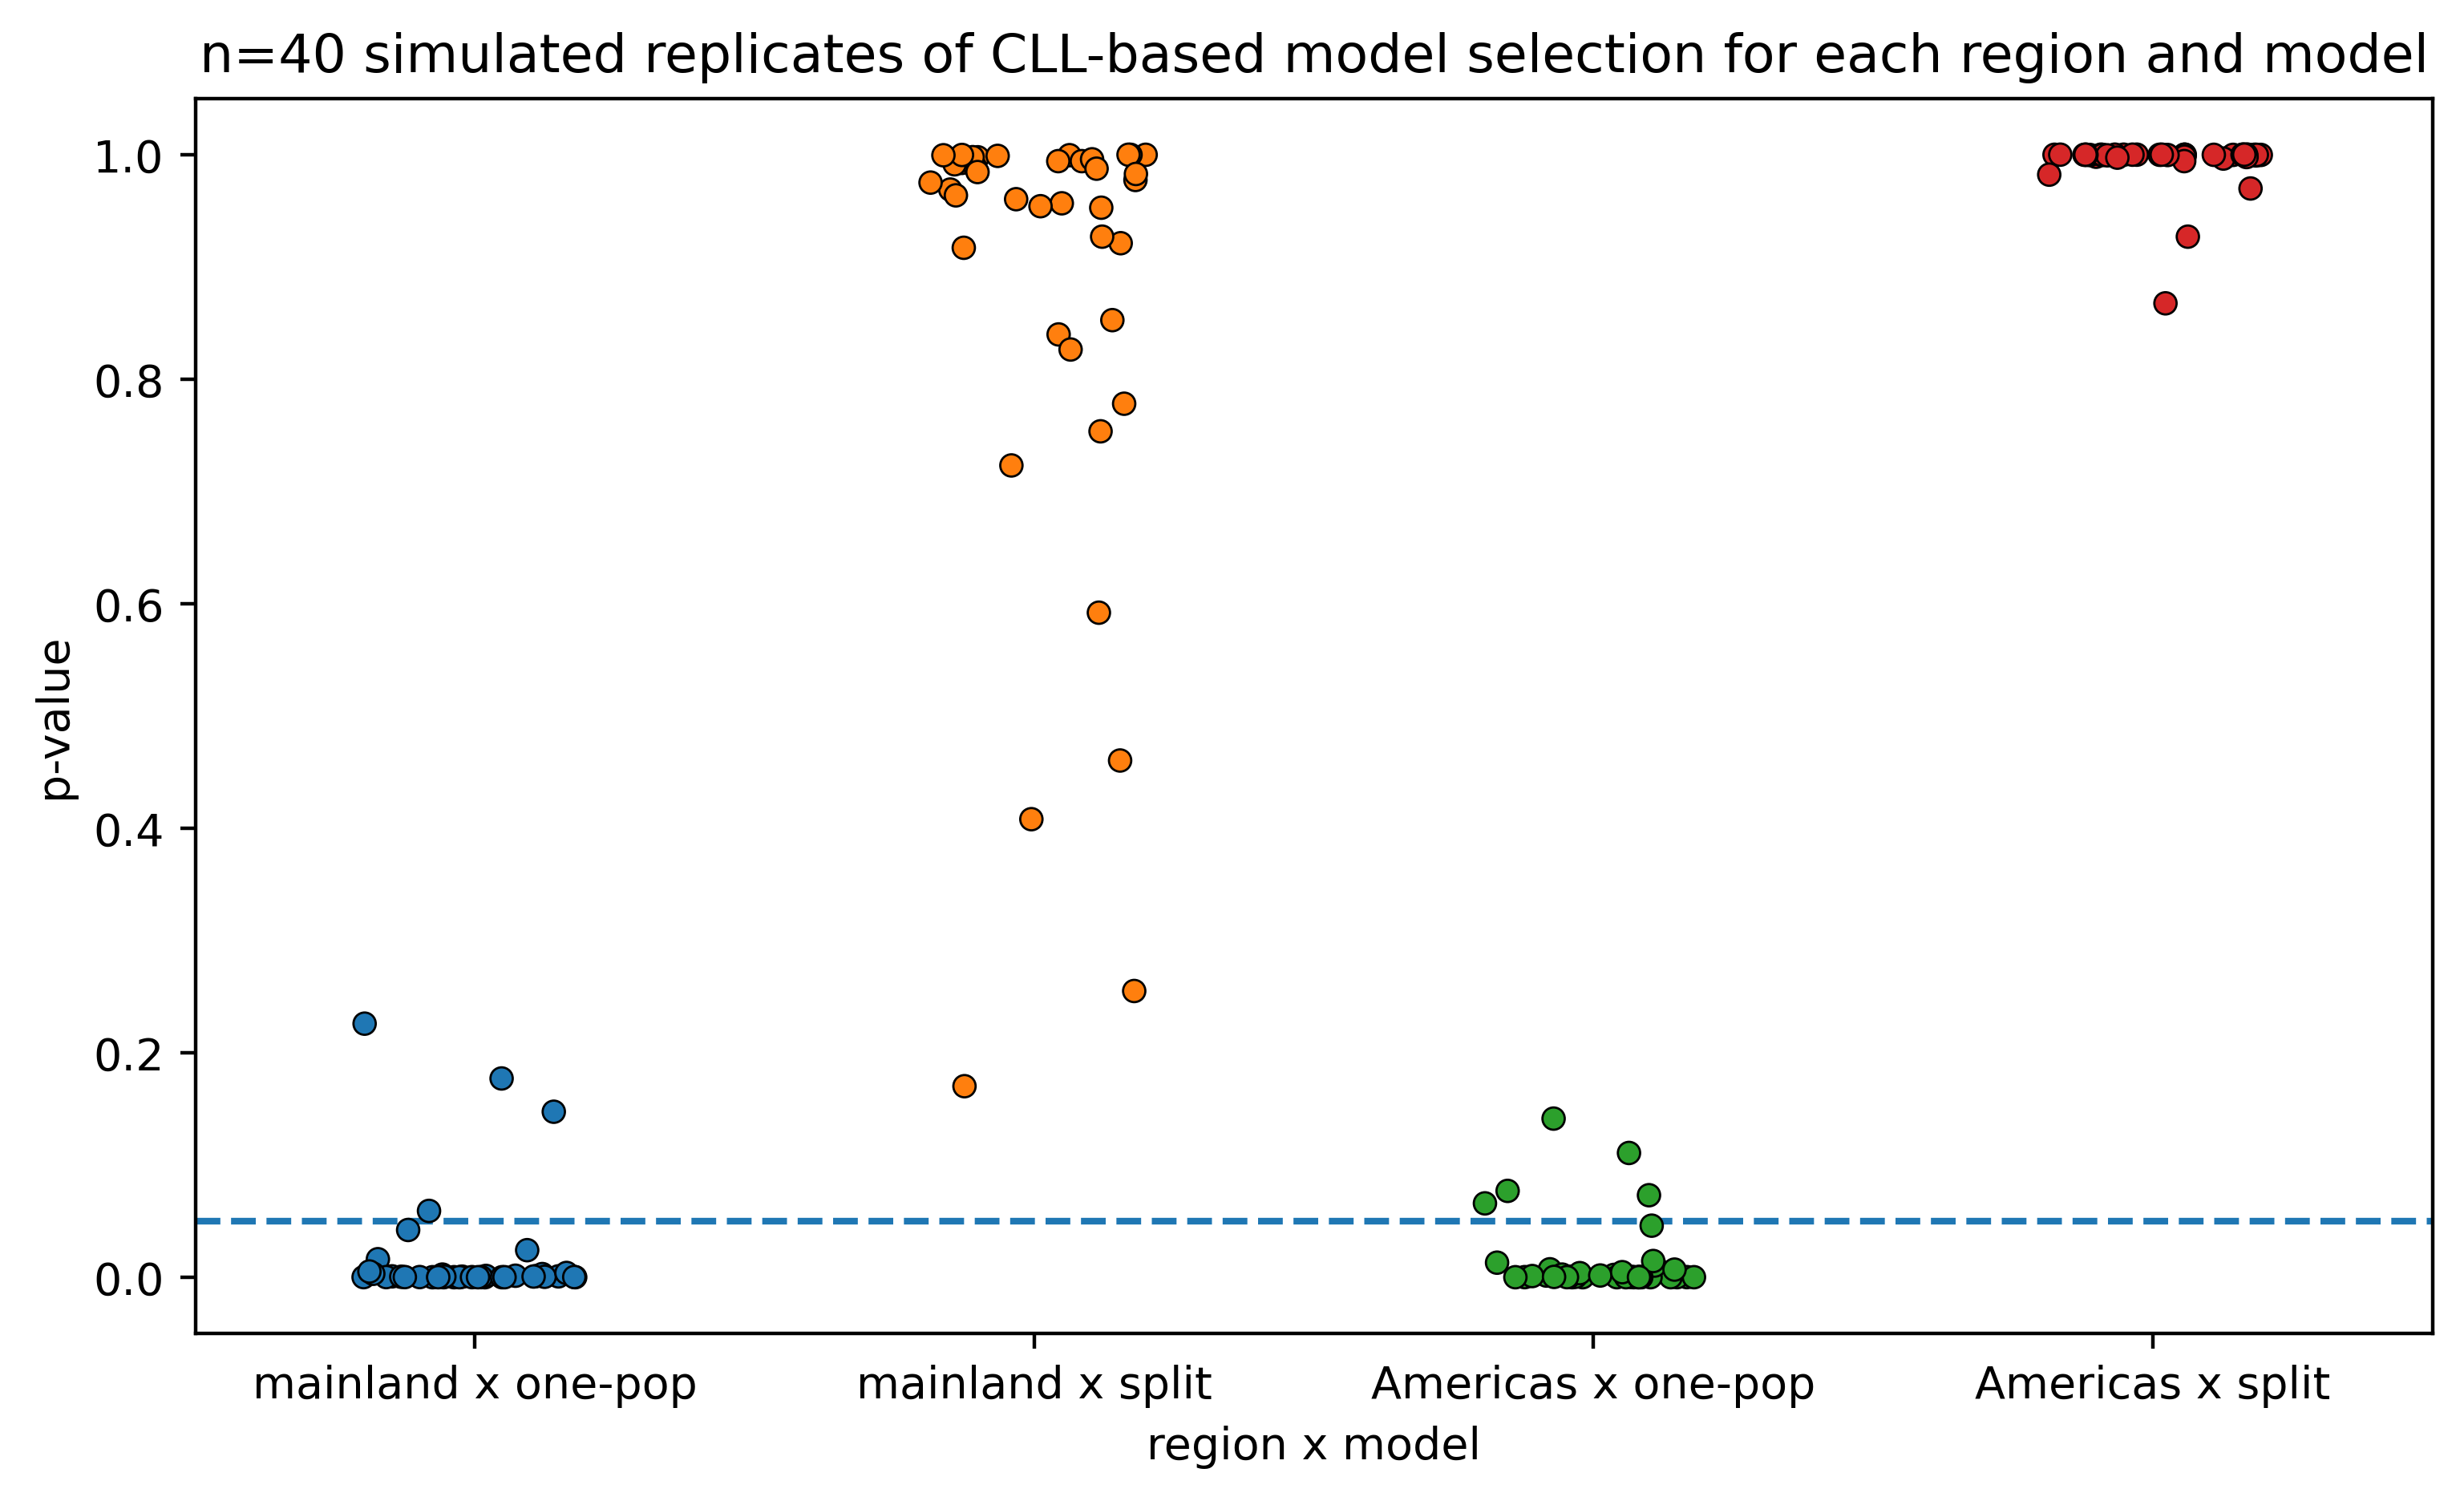

In [7]:
fig, ax = plt.subplots(figsize=(9, 5), dpi=400)
sns.stripplot(data=p_vals_df, ax=ax, jitter=0.2, edgecolor='black', linewidth=0.5)
ax.set_ylabel('p-value')
ax.set_xlabel('region x model')
ax.set_title('n=40 simulated replicates of CLL-based model selection for each region and model')
ax.axhline(0.05, ls='--')
plt.show()